# LOH.1 benchmark with ExaHyPE 2

I assume that you've done the Euler example already, i.e. I can skip most of the basic stuff and go into medias res straightaway.

Compare to the Euler example, this is a more sophisticated example which uses an FV solver with nonconservative product. The example simulates elastic wave equations plus a diffuse interface model that takes material  interfaces into account.

Currently, we impose a Gaussian velocity pulse as initial solution but we will eventually simulate the LOH.1 benchmark.

We solve the governing equations using (a very diffusive) first-order FV solver. The code relies on snippets from the first version of ExaHyPE and from ExaSeis.

* Fore more details on the underlying mathematical modelling, see:
  https://www.sciencedirect.com/science/article/pii/S0021999119300786 

* For more details on the benchmark problem, see:
  http://sismowine.org/model/WP2_LOH1.pdf

* For more details on ExaSeis, see e.g.:
  https://mediatum.ub.tum.de/doc/1483700/1483700.pdf 


In [1]:
import os
import peano4
import exahype2

DaStGen 2 (C) www.peano-framework.org
Peano 4 (C) www.peano-framework.org
ExaHyPE 2 (C) www.peano-framework.org


In [2]:
project = exahype2.Project( 
  namespace    = ["examples", "exahype2", "loh1"], 
  project_name = "loh1", 
  directory    = "." )

Compared to the Euler equations, the big difference is that we use the ncp (non-conservative product). That is, we solve an equation with an additional term: 


$ \partial Q + \nabla ^T \cdot F(Q) + B(Q) \nabla Q = 0$

It might come as a surprise that we omit any conservative term (flux) here, but I explain this below:

In [3]:
mesh_size      = 0.01
time_step_size = 0.001

project.add_solver(  
  exahype2.solvers.GenericRusanovFVFixedTimeStepSizeWithEnclaves(
    name           = "LOH1", 
    patch_size     = 5, 
    unknowns       = 3+6,      # vel(3) + stress(6)
    auxiliary_variables = 4,   #material parameters(3) + diffuse interface(1)  
    time_step_size = 0.01, 
    min_h          = mesh_size,
    max_h          = mesh_size,
    flux           = False, 
    ncp            = True,
    use_gpu        = False) )

While I personally always prefer to play around with Euler and 2d before I switch to Euler 3d, this time a 2d solve does not make any real sense. So we use 3d right from the start. The domain dimensions here are those from the standard benchmark.

In [4]:
dimensions=3 
project.set_global_simulation_parameters(
  dimensions            = dimensions,
  offset                = [0.0]*dimensions, 
  size                  = [30.0]*dimensions,
  #end_time              = 2.0,        
  end_time              = 0.1,
  first_plot_time_stamp = 0.0, 
  time_in_between_plots = time_step_size*10
)


The whole test is already relative compute-heavy, so we rely on parallelisation. The parameter clarifies that we want to work with an (MPI) domain decomposition that is 90% close to the optimum. The parameter allows us to balance between good domain decompositions and (very) long domain partitioning times.

In [5]:
project.set_load_balancing( "toolbox::loadbalancing::RecursiveSubdivision", "(0.9)" )

Finally, we generate the code. The actual implementation of the terms

$ \frac{\partial}{\partial t} \begin{pmatrix}
\sigma \\ \rho \ v
\end{pmatrix}
+
\nabla\cdot\begin{pmatrix}
{j}\\
\frac{1}{\rho}j\otimes j + p I \\
\frac{1}{\rho}j\,(E + p)
\end{pmatrix}
= 0
 $ 

and others can be found in the cpp files in the current directory. (this LaTeX formulation is yet to be finalised)

In [6]:
build_mode = peano4.output.CompileMode.Asserts
#build_mode = peano4.output.CompileMode.Release
#build_mode = peano4.output.CompileMode.Trace


project.set_Peano4_installation("../../..", build_mode)

peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is mpiicpc
used Fortran compiler is ifort
generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated loh1-main.cpp
write ./Makefile
write ././AbstractLOH1.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/GenericRusanovFVFixedTimeStepSizeWithEnclavesAbstract.template.h)
write ././AbstractLOH1.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/GenericRusanovFVFixedTimeStepSizeWithEnclavesAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/LOH1Q.h (generated from template /home/tobias/git/Peano/py

In [7]:
parallel_builds = 8   # I don't use a massively parallel build here as my laptop otherwise becomes too hot.
                      # Without any arguments, the build process will grab all of your cores.
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

clean up project ...
clean complete
start to compile with concurrency level of 8 ...
compile complete


## Run benchmark and analyse outcome

In [8]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output.txt", rebuild_if_required=False )

run application ...
run complete


True

In [9]:
import exahype2

performance_data = exahype2.postprocessing.PerformanceData( "output.txt", verbose=True )

parse output.txt
triggered plot at 55.181321651s
started new time step at 55.404961683s
started new time step at 55.649032454s
triggered plot at 55.88066869s
started new time step at 56.107545699s
started new time step at 56.378029489s
triggered plot at 56.610787438s
started new time step at 56.839989791s
started new time step at 57.111995891999996s
triggered plot at 57.357368058s
started new time step at 57.577878602s
started new time step at 57.824627163s
triggered plot at 58.072906036s
started new time step at 58.303857639s
started new time step at 58.575607243s
triggered plot at 58.819991918s
started new time step at 59.049864446s
started new time step at 59.321617735s
triggered plot at 59.569205011s
started new time step at 59.79901168000001s
started new time step at 60.07010377s
triggered plot at 60.301058626999996s
started new time step at 60.53250937s
started new time step at 60.79991896400001s
triggered plot at 61.033718898s
started new time step at 61.261544767s
started new t

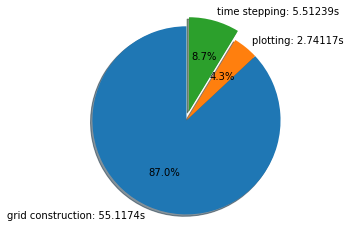

In [10]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

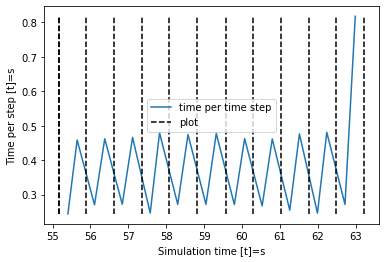

In [11]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

In [12]:
import peano4.visualisation

peano_output_files = "solution-LOH1"
convert = peano4.visualisation.Convert( peano_output_files, True )
convert.set_visualisation_tools_path( "../../../src/convert" )
convert.extract_fine_grid()
convert.convert_to_vtk()

inspect file solution-LOH1 ... 
invoke ['../../../src/convert/convert', 'inspect', 'solution-LOH1.peano-patch-file']
found selectors {'LOH1Q'}
extract fine grid from solution-LOH1 ... 
inspect file solution-LOH1 ... 
invoke ['../../../src/convert/convert', 'inspect', 'solution-LOH1.peano-patch-file']
found selectors {'LOH1Q-fine-grid', 'LOH1Q'}
convert file solution-LOH1 into vtk (vtu binary format) ... 


See remarks in Euler example how to postprocess these data if you wanna integrate it into your notebook. Otherwise, just open Paraview or VisIt.